### Functions

In [ ]:
#!pip install --upgrade wandb
#!wandb login xxxxxxxxxxxxxxxxxx

In [ ]:
#import wandb
#from wandb.keras import WandbCallback

In [ ]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import tqdm
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
#import wandb

%matplotlib inline

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD

import keras.layers.advanced_activations as advanced_activations
import keras.activations as activations
import keras.layers as layers
from keras.layers import Dense, concatenate
from keras.callbacks import EarlyStopping

In [ ]:
def shuffle_weights(model, weights=None):
    """Randomly permute the weights in `model`, or the given `weights`.
    This is a fast approximation of re-initializing the weights of a model.
    Assumes weights are distributed independently of the dimensions of the weight tensors
      (i.e., the weights have the same distribution along each dimension).
    :param Model model: Modify the weights of the given model.
    :param list(ndarray) weights: The model's weights will be replaced by a random permutation of these weights.
      If `None`, permute the model's current weights.
    """
    if weights is None:
        weights = model.get_weights()
    weights = [np.random.permutation(w.flat).reshape(w.shape) for w in weights]
    # Faster, but less random: only permutes along the first dimension
    # weights = [np.random.permutation(w) for w in weights]
    model.set_weights(weights)

In [ ]:
import scipy.spatial.distance as distance
def plot_mat_accuracy(input, y_hat, y_true):

  input = input
  y_hat = y_hat
  y_true = y_true

  dist = distance.cosine(y_hat.flatten(), y_true.flatten())

  fig, axs = plt.subplots(1,3)
  fig.suptitle('Accuracy: {}'.format(1 - dist))
  
  axs[0].set_title("Input")
  axs[0].matshow(input)

  axs[1].set_title("Y_hat")
  axs[1].matshow(y_hat)

  axs[2].set_title("Y_true")
  axs[2].matshow(y_true)
  
  for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

  plt.show()
      
  return 1 - dist

def get_mat_accuracy(y_hat, y_true):
  dist = distance.cosine(y_hat.flatten(), y_true.flatten())
  return 1 - dist

### Data Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

%cd drive/My\ Drive/SWE

Mounted at /content/drive/
/content/drive/My Drive/SWE


In [ ]:
portate = np.load('datasets/numpy/portate.npy')
print(portate.shape)

wses = np.load('datasets/numpy/wses.npy')
print(wses.shape)

btms = np.load('datasets/numpy/btms.npy')
print(btms.shape)

(100, 1, 3, 4)
(100, 1, 448, 640)
(100, 1, 448, 640)


### CNN

#### Data preprocessing

In [ ]:
# Tolgo 2* dimensione che incapsula
btms.resize(btms.shape[0], btms.shape[2], btms.shape[3])
wses.resize(wses.shape[0], wses.shape[2], wses.shape[3])

In [ ]:
portate.resize(portate.shape[0], portate.shape[2], portate.shape[3])

In [ ]:
# (time index, portata)
portate = portate[:, :, [0,2]]

In [ ]:
print(portate.shape)
print(btms.shape)
print(wses.shape)

(100, 3, 2)
(100, 448, 640)
(100, 448, 640)


In [ ]:
TRAIN_SIZE = int(wses.shape[0] * 0.9)

train_indices = np.unique(random.sample(list(range(portate.shape[0])), TRAIN_SIZE))
test_indices = [i for i in range(wses.shape[0]) if i not in train_indices]

# 2 input, 1 output
x_train_img, y_train = btms[train_indices], wses[train_indices]
x_train_prt = portate[train_indices]

# 2 input, 1 output
x_test_img, y_test = btms[test_indices], wses[test_indices]
x_test_prt = portate[test_indices]

In [ ]:
# Reshape to channel last
x_train_img = x_train_img.reshape(-1, x_train_img.shape[1], x_train_img.shape[2], 1)
x_test_img = x_test_img.reshape(-1, x_test_img.shape[1], x_test_img.shape[2], 1)

y_train = y_train.reshape(-1, y_train.shape[1], y_train.shape[2], 1)

#### Modeling

Parametri piú rilevanti:

1.   Convolution Blocks (val_accuracy alta)
2.   Neuroni Densi alla fine (immagine chiara)
3.   Kernel Size (smoothing + dettagli)
4.   Leaky ReLU Slope (smoothing)



In [ ]:
hyperparameters = dict(
    
    convolution_blocks = 16, # da 8 comincia a migliorare la val_accuracy!!
    dense_blocks = 4,

    res_net = False,
    skips = 2,

    filters = 8,        # X canali in uscita

    kernels = (27, 27), # 3 = minimo odd number valido
                        # 2 = asimmetrico, filtro irregolare
                        # 1 = come se non ci fossero vicini
                        # forse un kernel piú grosso aiuta a stabilizzare l'accuracy
                       
    dense = 1024,
    lstm = 16, 

    epochs = 100,

    lrelu_slope = 0.5,

    optimizer = "adam",  # SGD converge meglio di Adam, ma é molto piú lento
    sgd_momentum = 0.9,

    learning_rate = 1e-3,
    batch_size = 64
)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout, Add
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model

In [ ]:
def feed_forward(config, dim, regress=False):
    
  inputs = Input(shape = dim)

  x = inputs
  x = LSTM(config["lstm"])(inputs)
  x = layers.Flatten()(x)
  x = BatchNormalization()(x)

  #x = Dense(16)(x)
  #x = layers.LeakyReLU(x)
  #x = Dense(32)(x)

  return Model(inputs, x)

In [ ]:
def build_cnn(config, width, height, depth, regress=False):

  inputShape = (height, width, depth)
  chanDim = -1

  inputs = Input(shape = inputShape)

  x = inputs

  x = BatchNormalization(axis=chanDim)(x)

  # 0, 1, 2, 3
  for i in range(config["convolution_blocks"]):

    x = Conv2D(config["filters"], config["kernels"], padding="same")(x)
  
    # Inner connections 2 
    if config["res_net"]:   
      y = Conv2D(config["filters"], config["kernels"], padding="same")(x)
      y = BatchNormalization()(y)

      for j in range(config["skips"] - 1):
        y = Conv2D(config["filters"], config["kernels"], padding="same")(y)
        y = BatchNormalization()(y)

      # Skip connection
      x = Add()([x, y])
    
    x = BatchNormalization(axis=chanDim)(x)

    # Applica N/2 poolings
    if i % 2 == 0:
      x = AveragePooling2D(2)(x)

    #x = layers.LeakyReLU(config["lrelu_slope"])(x)

  # Final dense
  x = Flatten()(x)

  model = Model(inputs, x)

  return model

In [ ]:
def train(config = None):

  #with wandb.init(config = config, project="shallow-water-emulations", entity="diego-calanzone"):
        
    #config = wandb.config

  # Build the network
  mlp = feed_forward(config, (portate.shape[1], portate.shape[2]), regress=False)
  cnn = build_cnn(config, x_train_img.shape[2], x_train_img.shape[1], x_train_img.shape[3])
  combinedInput = concatenate([mlp.output, cnn.output])

  # Dense blocks
  for i in range(config["dense_blocks"]):
    x = Dense(config["dense"])(combinedInput)
    x = BatchNormalization()(x)

  # Final Reshape
  x = Dense(y_train.shape[2] * y_train.shape[1])(x)
  x = layers.LeakyReLU(config["lrelu_slope"])(x)

  x = Reshape((y_train.shape[1], y_train.shape[2], y_train.shape[3]))(x)

  model = Model(inputs=[mlp.input, cnn.input], outputs=x)

  # Compile
  if config["optimizer"] == 'adam':
    opt = Adam(lr=config["learning_rate"])
  else:
    opt = SGD(lr=config["learning_rate"], momentum=config["sgd_momentum"])

  model.compile(loss="mean_squared_error", optimizer=opt, metrics=["accuracy"])
  tf.keras.utils.plot_model(model, to_file="model_plot.png", show_shapes=True)

  # Train
  model.fit(
    x = [x_train_prt, x_train_img], 
    y =  y_train,
    validation_data = ([x_test_prt, x_test_img], y_test),
    epochs = config["epochs"], 
    shuffle = 1,
    batch_size = config["batch_size"],
    verbose = 1,
    #callbacks=[WandbCallback()]
  )

  return model

In [ ]:
model = train(hyperparameters)

Epoch 1/100
2/2 [==============================] - 37s 10s/step - loss: 11.9788 - accuracy: 0.7624 - val_loss: 10.5736 - val_accuracy: 0.7905
Epoch 2/100
2/2 [==============================] - 5s 2s/step - loss: 11.7818 - accuracy: 0.7616 - val_loss: 10.5676 - val_accuracy: 0.7905
Epoch 3/100
2/2 [==============================] - 5s 2s/step - loss: 11.5618 - accuracy: 0.7588 - val_loss: 10.5634 - val_accuracy: 0.7905
Epoch 4/100
2/2 [==============================] - 5s 2s/step - loss: 11.2254 - accuracy: 0.7560 - val_loss: 10.5574 - val_accuracy: 0.7905
Epoch 5/100
2/2 [==============================] - 5s 2s/step - loss: 10.9518 - accuracy: 0.7543 - val_loss: 10.5416 - val_accuracy: 0.7905
Epoch 6/100
2/2 [==============================] - 5s 2s/step - loss: 10.6876 - accuracy: 0.7538 - val_loss: 10.5139 - val_accuracy: 0.7905
Epoch 7/100
2/2 [==============================] - 5s 2s/step - loss: 10.4981 - accuracy: 0.7548 - val_loss: 10.4822 - val_accuracy: 0.7905
Epoch 8/100
2/2 [=

In [ ]:
model.evaluate([x_test_prt, x_test_img], y_test)

1/1 [==============================] - 0s 200ms/step - loss: 1.6153 - accuracy: 0.7193


[1.61528742313385, 0.7192658185958862]

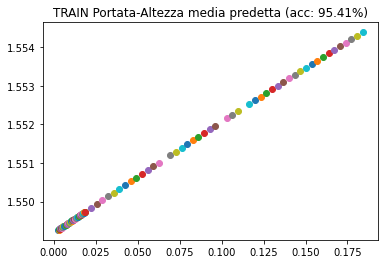

In [ ]:
acc = []

for i in range(x_train_img.shape[0]):
  predict = model.predict([np.array([x_train_prt[i]]), np.array([x_train_img[i]])])
  
  # Accuracy
  acc.append(get_mat_accuracy(predict.reshape(448, 640), y_train[i].reshape(448, 640)))
  
  # portata, altezza media prevista
  plt.scatter(x_train_prt[i][1][1], np.mean(predict))

avg_acc = round(np.mean(acc)*100, 2)
plt.title("TRAIN Portata-Altezza media predetta (acc: {}%)".format(avg_acc))

plt.show()

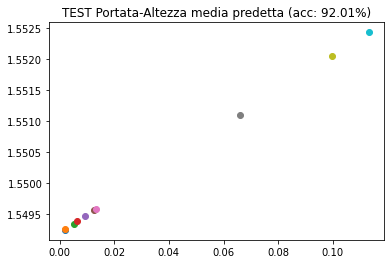

In [ ]:
plt.title("TEST Portata-Altezza media predetta")
acc = []

for i in range(x_test_img.shape[0]):
  predict = model.predict([np.array([x_test_prt[i]]), np.array([x_test_img[i]])])
  
  # Accuracy
  acc.append(get_mat_accuracy(predict.reshape(448, 640), y_test[i].reshape(448, 640)))
  
  # portata, altezza media prevista
  plt.scatter(x_test_prt[i][1][1], np.mean(predict))

avg_acc = round(np.mean(acc)*100, 2)
plt.title("TEST Portata-Altezza media predetta (acc: {}%)".format(avg_acc))

plt.show()

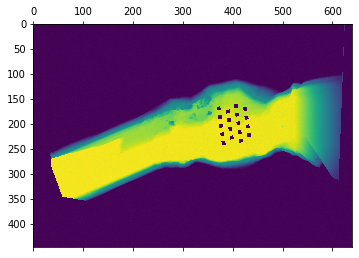

In [ ]:
plt.matshow(model.predict([np.array([x_test_prt[5]]), np.array([x_test_img[5]])]).reshape(448, 640))